# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
url = 'http://www.indeed.com/jobs?q=data+scientist&l=nyc&start=10'

In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
import requests
import bs4
%matplotlib inline
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.grid_search import GridSearchCV

In [3]:
r = requests.get(url)
soup = BeautifulSoup(r.content, "lxml")

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [4]:
#This function scrapes the location from the given url

def location(soupy):
    loc = soupy.findAll(class_='location')

    locations = []
    for i in loc:
        try:
            locations.append(i.text)
        except:
            locations.append(np.nan)
    return locations

locations = location(soup)

In [5]:
#This function scrapes the company name from the given url

def company(soupy):
    company = soupy.findAll(class_='company')
    companies = []
    for i in company:
        try:
            companies.append(i.text.strip().encode('ascii','ignore'))
        except:
            companies.append(np.nan)
    return companies

companies = company(soup)

In [6]:
#This function scrapes the location from the given url

def job(soupy):
    title = soupy.findAll(class_='jobtitle')
    titles = []
    for i in title:
        try:
            titles.append(i.text.strip().encode('ascii','ignore'))
        except:
            titles.append(np.nan)
    return titles
    
titles = job(soup)

In [7]:
#This function scrapes the salary from the given url

def salary(soupy):
    salary = soupy.findAll('nobr' or 'sjcl')
    salaries = []
    for i in salary:
        try:
            salaries.append(i.get_text().strip().encode('ascii','ignore'))
        except:
            salaries.append(np.nan)
    return salaries

salaries = salary(soup)

In [54]:
#Adds the pulled data into a dataframe

df = pd.DataFrame([titles, companies, locations, salaries]).T
df.columns = ['title', 'company', 'locations','salary']
df.head()

,title,company,locations,salary
0,Junior Data Scientist,UncommonGoods,"New York, NY",relevance -\n date
1,Data Scientist Predictive Analytics,Gallup,"New York, NY",$800 a day
2,Data Scientist & Analytics Developer,Lancer Insurance Company,"Long Beach, NY",About
3,Data Scientist,Brilliant Leap,"New York, NY",None
4,"Research Associate, R&D","Stemline Therapeutics, Inc.","New York, NY 10022 (Midtown area)",None


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [55]:
#cycles through each of the cities listed and the results pages pulling the job data and appending to results

url_template = 'http://www.indeed.com/jobs?q=data+scientist&l={}&start={}'

max_results_per_city = 500

results = [[],[],[],[]]

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Miami', 'Atlanta','Los+Angeles', 'Chicago'\
                 'Houston','Seattle','Phoenix','Houston','San+Diego']):
    for start in range(0, max_results_per_city, 10):
        response = requests.get(url_template.format(city,start))
        page = response.text
        soup = BeautifulSoup(page,'lxml')
        results[0].extend(location(soup))
        results[1].extend(company(soup))
        results[2].extend(job(soup))
        results[3].extend(salary(soup))
        pass

#reduce(lambda x, y: x.extend(y), results)


#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [56]:
#creates dataframe df with all of the results for each city

df = pd.DataFrame([results[2], results[1], results[0], results[3]]).T
df.columns = ['title', 'company', 'location','salary']
df.head()

,title,company,location,salary
0,Computational Scientist,MD ANDERSON CANCER CENTER,"Houston, TX",relevance -\n date
1,Machine Learning Expert,Arundo Analytics,"Houston, TX",About
2,Quantitative Marketing Analyst,Numeric Jobs,"Houston, TX",relevance -\n date
3,Data Scientist,Panton,"Houston, TX","$160,000 a year"
4,Senior Data Scientist,Shell,"Houston, TX",About


Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [57]:
#cleans salary data by turning alpha strings to nans and dropping any salaries not in annual terms

def salarydrop(value):
    c=0
    #value = value.encode('utf8')
    value = value.split()
    if 'relevance' in value: 
        return 'nan'
    for i in value:
        if i.isalpha() == True:
            c+=1
            if c == len(value):
                return 'nan'
            
    todrop = ['hourly','hour', 'weekly','week','monthly','month','day','daily']
    for i in todrop:
        if i in value:
            return 'drop'
    return " ".join(value)
        
    
df['salary'] = df['salary'].astype(str)
df['salary'] = df['salary'].to_frame().applymap(salarydrop)
df = df[df['salary']!='drop']
df.salary.unique()

array(['nan', '$160,000 a year', '$49,506 a year', '$70,000 a year',
       '$93,431 a year', '$51,600 - $77,400 a year',
       '$60,000 - $75,000 a year', '$54,590 a year',
       '$28,909 - $36,000 a year', '$67,632 a year',
       '$60,000 - $95,000 a year', '$85,000 - $115,000 a year',
       '$90,000 - $100,000 a year', '$48,000 a year',
       '$50,000 - $55,000 a year', '$105,000 a year', '$71,000 a year',
       '$115,000 - $150,000 a year', '$80,000 - $110,000 a year',
       '$110,000 - $200,000 a year', '$125,000 a year', '$85,000 a year',
       '$95,000 a year', '$138,300 a year', '$140,000 a year',
       '$145,000 a year', '$150,000 a year', '$110,000 - $160,000 a year',
       '$80,000 - $100,000 a year', '$185,000 a year',
       '$50,000 - $60,000 a year', '$100,000 - $120,000 a year',
       '$100,000 - $140,000 a year', '$150,000 - $200,000 a year',
       '$120,000 a year', '$110,000 - $150,000 a year',
       '$70,000 - $110,000 a year', '$165,000 a year',
      

In [58]:
df.head()

,title,company,location,salary
0,Computational Scientist,MD ANDERSON CANCER CENTER,"Houston, TX",nan
1,Machine Learning Expert,Arundo Analytics,"Houston, TX",nan
2,Quantitative Marketing Analyst,Numeric Jobs,"Houston, TX",nan
3,Data Scientist,Panton,"Houston, TX","$160,000 a year"
4,Senior Data Scientist,Shell,"Houston, TX",nan


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [59]:
#removes the '$' from salary and returns a float. If salary is listed as range, the mean will be returned

def salaryfix(value):
    c=0
    value = str(value)
    if value.isalpha == True:
        return value
    if "a year" in value:
        value = value[:-6]
    if "-" in value:
        value = value.split('-')
        for nums in value:
            value = salaryfix(nums)
            c+=1
            if c==1:
                thesum=0
            thesum += value
        return thesum/2
    value = str(value)
    value = value.replace('$', '')
    value = value.replace(',', '')
    value = float(value)
    return value

df['salary'] = df['salary'].to_frame().applymap(salaryfix)

In [60]:
#this function removes any characters after the ',' in the city column

def cityfix(value):
    value = str(value)
    value = value.split(',')
    return value[0]

df['location'] = df['location'].to_frame().applymap(cityfix)

In [61]:
#removes any duplicate entries

df = df.drop_duplicates()
df.head()

,title,company,location,salary
0,Computational Scientist,MD ANDERSON CANCER CENTER,Houston,NaN
1,Machine Learning Expert,Arundo Analytics,Houston,NaN
2,Quantitative Marketing Analyst,Numeric Jobs,Houston,NaN
3,Data Scientist,Panton,Houston,160000.0
4,Senior Data Scientist,Shell,Houston,NaN


### Save your results as a CSV

In [62]:
#df.to_csv('jobresults.csv')

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [63]:
df2 = pd.read_csv('jobresults.csv')

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [64]:
#this function returns a true value if the salary is higher than the median


median = df.salary.median()

def salarybool(value):
    if value >= median:
        return True
    else: return False
    
df['salaryhigh'] = df.salary.to_frame().applymap(salarybool)
df.head(10)

,title,company,location,salary,salaryhigh
0,Computational Scientist,MD ANDERSON CANCER CENTER,Houston,NaN,False
1,Machine Learning Expert,Arundo Analytics,Houston,NaN,False
2,Quantitative Marketing Analyst,Numeric Jobs,Houston,NaN,False
3,Data Scientist,Panton,Houston,160000.0,True
4,Senior Data Scientist,Shell,Houston,NaN,False
5,Research Scientist,"GeoControl Systems, Inc.",Houston,NaN,False
6,Marketing Data Scientist,Alert Logic,Houston,49506.0,False
7,Data Scientist - Houston,"Amazon Web Services, Inc.",Houston,NaN,False
8,Data Scientist,IHS,Houston,NaN,False
9,Research Statistical Analyst,MD ANDERSON CANCER CENTER,Houston,70000.0,False


#### Thought experiment: What is the baseline accuracy for this model?

The baseline accuracy is 50/50 because we used the median salary as our binary determinant. 

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [65]:
#location, salary, and the boolean salary variable have been pulled out and dummy variables created for each location.


tempdf = df[df['salary']>0]
locationdf = tempdf[['location','salary','salaryhigh']]


locationdf['key'] = range(len(locationdf['location']))
locationdf = pd.concat([locationdf.drop('key',axis=1),pd.get_dummies(locationdf['location'])], axis = 1)
locationdf['constant'] = 1
#del locationdf['Spring']
locationdf.head()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,location,salary,salaryhigh,Gilbert,Glendale,Houston,Mesa,Phoenix,Scottsdale,Spring,Tempe,United States,constant
3,Houston,160000.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,Houston,49506.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,Houston,70000.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
10,Houston,93431.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19,Houston,64500.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [66]:
#sets target and data variables and prints shape

X = locationdf[list(locationdf.columns[3:])]
y = locationdf.salaryhigh
print X.shape
print y.shape

(217, 10)
(217,)


In [67]:
#fits statsmodel logistic regression model based on test and target data

model = sm.Logit(y,X)
model_fit = model.fit(method = 'bfgs')
model_fit.summary()

         Current function value: 0.682864
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36


//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             salaryhigh   No. Observations:                  217
Model:                          Logit   Df Residuals:                      208
Method:                           MLE   Df Model:                            8
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                 0.01410
Time:                        02:42:37   Log-Likelihood:                -148.18
converged:                      False   LL-Null:                       -150.30
                                        LLR p-value:                    0.8351
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Gilbert           2.1715   2.84e+06   7.66e-07      1.000     -5.56e+06  5.56e+06
Glendale          2.1715   2.84e+06   7.66e-07      1.000     -5.56e+06  5.56e+06
Houston          -0.3119   2.84e+06   -1.1e-07      1.000     -5.56e+06  5.56e+06
Mesa             -0.2806   2.84e+06  -9.89e-08      1.000     -5.56e+06  5.56e+06
Phoenix          -0.2621   2.84e+06  -9.24e-08      1.000     -5.56e+06  5.56e+06
Scottsdale       -0.7730   2.84e+06  -2.73e-07      1.000     -5.56e+06  5.56e+06
Spring           -2.4451   2.84e+06  -8.62e-07      1.000     -5.56e+06  5.56e+06
Tempe            -0.3033   2.84e+06  -1.07e-07      1.000     -5.56e+06  5.56e+06
United States     0.4294   2.84e+06   1.51e-07      1.000     -5.56e+06  5.56e+06
constant          0.3965   2.84e+06    1.4e-07      1.000     -5.56e+06  5.56e+06
=================================================================================
"""

The magnitude of the coefficients represent the salaries in that city relative to the median salary.

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [68]:
#this function adds a field for title level and returns level based on key words in title

def titlelevel(value):
    value = str(value)
    if 'Manager' in value:
        return 'manager'
    elif 'Director' in value:
        return 'director'
    elif 'VP' in value:
        return 'vp'
    elif 'Chief' in value:
        return 'chief'
    elif 'Analyst' in value:
        return 'analyst'
    elif 'Scientist' in value:
        return 'scientist'
    elif 'Engineer' in value:
        return 'engineer'
    else: return 'other'

locationdf['titlelevel'] = df.title.to_frame().applymap(titlelevel)

In [69]:
locationdf.head()

,location,salary,salaryhigh,Gilbert,Glendale,Houston,Mesa,Phoenix,Scottsdale,Spring,Tempe,United States,constant,titlelevel
3,Houston,160000.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,scientist
6,Houston,49506.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,scientist
9,Houston,70000.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,analyst
10,Houston,93431.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,scientist
19,Houston,64500.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,manager


#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [70]:
# import patsy
# f = 'y ~ x'
# y, X = patsy.dmatrices(f, df, return_type='dataframe')
# sm.Logit(y, X).fit().summary()

In [71]:
#titlelevel, salary, and the boolean salary variable have been pulled out and dummy variables created for each title level.

locationdf['key'] = range(len(locationdf['titlelevel']))
locationdf = pd.concat([locationdf.drop('key',axis=1),pd.get_dummies(locationdf['titlelevel'])], axis = 1)
locationdf['constant'] = 1
del locationdf['scientist']
del locationdf['titlelevel']
locationdf.head()

,location,salary,salaryhigh,Gilbert,Glendale,Houston,Mesa,Phoenix,Scottsdale,Spring,Tempe,United States,constant,analyst,director,engineer,manager,other
3,Houston,160000.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
6,Houston,49506.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
9,Houston,70000.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0
10,Houston,93431.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0
19,Houston,64500.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0


In [72]:
#fits the features (X) and the salaryhigh (T/F) to the logistic regression model

model = LogisticRegression()
X = locationdf[list(locationdf.columns[3:])]
y = locationdf.salaryhigh

model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
#predicts salaryhigh T/F as well as prints the confusion matrix

lr = LogisticRegression(solver='liblinear')
ypredict = model.predict(X)
cm = confusion_matrix(y,ypredict)
dfcm = pd.DataFrame(cm, columns=['Predicted High','Predicted Low'], index=['Actual High','Actual Low'])
dfcm

,Predicted High,Predicted Low
Actual High,46,59
Actual Low,34,78


In [75]:
cross_val_score(lr, X, y, cv=3).mean()

0.45630390664637238

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

acc = accuracy_score(y, ypredict)
pres = precision_score(y, ypredict)
reca = recall_score(y, ypredict)
auc = auc(y, ypredict)
print "Accuracy Score: %f"%(acc)
print "Precision Score: %f"%(pres)
print "Recall Score: %f"%(reca)
print "AUC: %f"%(auc)

Accuracy Score: 0.571429
Precision Score: 0.569343
Recall Score: 0.696429
AUC: 33.000000


The Precision (58%) represents the actual positives (high salaries) over the all the predicted positives. 
The Recall (79%) represents the predicted positives over all actual positives regardless of prediction.
The AUC is the area under the ROC curve and increases with model accuracy.

A high precision model is ideal if you're choosing listings to apply to and don't want to waste your time on interviews if salary is actually lower than predicted. A high recall model is ideal if you have a small number of listings and do not want to miss any high salary positions due to a false negative.


In [77]:
import matplotlib.patheffects as path_effects

def plot_confusion_matrix(cm, title='Salary Predictions', labels=['High Salary','Low Salary'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()])

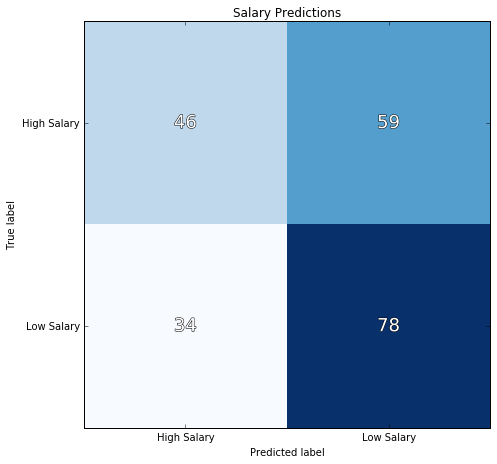

In [78]:
plot_confusion_matrix(cm)

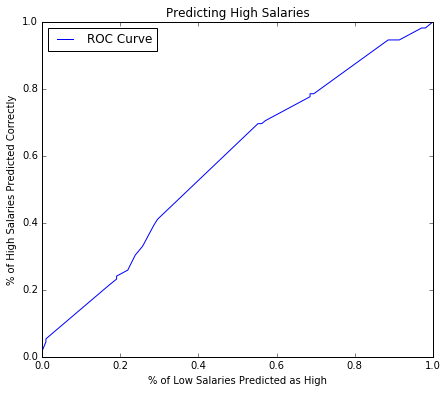

In [79]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    
proba = model.predict_proba(X).T[1]
roc = roc_curve(y,proba)
## Generate an ROC Curve in sklearn
getROCcurve(roc, title='Predicting High Salaries', ylabel='% of High Salaries Predicted Correctly',\
            xlabel='% of Low Salaries Predicted as High')

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [80]:
pdf = pd.DataFrame(X, columns=X.columns)
pdf['Target'] = y
pdf.head()

,Gilbert,Glendale,Houston,Mesa,Phoenix,Scottsdale,Spring,Tempe,United States,constant,analyst,director,engineer,manager,other,Target
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,True
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,False
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,False
10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,False
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,False


In [81]:
lr1 = LogisticRegression(penalty='l1')
lr2 = LogisticRegression(penalty='l2')

lr1_model = lr1.fit(X, y)
lr2_model = lr2.fit(X, y)
y1_pred = lr1.predict(X)
y2_pred = lr2.predict(X)

In [82]:
cm1 = confusion_matrix(y, y1_pred, labels=lr1.classes_)
cm1 = pd.DataFrame(cm1, columns=['Predicted High','Predicted Low'], index=['Actual High','Actual Low'])

cm2 = confusion_matrix(y, y2_pred, labels=lr2.classes_)
cm2 = pd.DataFrame(cm2, columns=['Predicted High','Predicted Low'], index=['Actual High','Actual Low'])

In [83]:
cm1

,Predicted High,Predicted Low
Actual High,105,0
Actual Low,0,112


In [84]:
cm2

,Predicted High,Predicted Low
Actual High,105,0
Actual Low,0,112


#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

In [85]:
df.company.unique

<bound method Series.unique of 0                 MD ANDERSON CANCER CENTER
1                          Arundo Analytics
2                              Numeric Jobs
3                                    Panton
4                                     Shell
5                  GeoControl Systems, Inc.
6                               Alert Logic
7                 Amazon Web Services, Inc.
8                                       IHS
9                 MD ANDERSON CANCER CENTER
10                             Schlumberger
11                                       GE
12                                   Panton
13                      The Hanover Company
14                                   Gallup
18                       Quantlab Financial
19                         Oscar Technology
20                                       BP
21                        Houston Methodist
22                                     CBRE
23                        Houston Methodist
25                   Sapient Global Markets
2

In [86]:
#this function adds a field for title level and returns level based on key words in title

def comkeyword(value):
    value = str(value)
    #value = value.encode('ascii','ignore')
    if 'Corp' in value:
        return 'corp'
    elif 'Analytics' in value:
        return 'analytics'
    elif 'University' in value:
        return 'university'
    elif 'Group' in value or 'group' in value:
        return 'group'
    elif 'Technology' in value or 'Technologies' in value:
        return 'tech'
    elif 'Software' in value:
        return 'software'
    elif 'Engineer' in value:
        return 'engineer'
    else: return 'other'

locationdf['keyword'] = df['company'].to_frame().applymap(comkeyword)

In [87]:
locationdf.head()

,location,salary,salaryhigh,Gilbert,Glendale,Houston,Mesa,Phoenix,Scottsdale,Spring,Tempe,United States,constant,analyst,director,engineer,manager,other,keyword
3,Houston,160000.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,other
6,Houston,49506.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,other
9,Houston,70000.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,0.0,other
10,Houston,93431.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,other
19,Houston,64500.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,1.0,0.0,tech


In [88]:
locationdf['key'] = range(len(locationdf['keyword']))
locationdf = pd.concat([locationdf.drop('key',axis=1),pd.get_dummies(locationdf['keyword'])], axis = 1)
locationdf['constant'] = 1
del locationdf['keyword']
#del locationdf['titlelevel']
locationdf.head()

,location,salary,salaryhigh,Gilbert,Glendale,Houston,Mesa,Phoenix,Scottsdale,Spring,...,engineer,manager,other,analytics,corp,group,other,software,tech,university
3,Houston,160000.0,True,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,Houston,49506.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,Houston,70000.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10,Houston,93431.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
19,Houston,64500.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [89]:
model = LogisticRegression()
X = locationdf[list(locationdf.columns[3:])]
y = locationdf.salaryhigh
model.fit(X, y)
lr = LogisticRegression(solver='liblinear')
ypredict = model.predict(X)
cm = confusion_matrix(y,ypredict)
dfcm = pd.DataFrame(cm, columns=['Predicted High','Predicted Low'], index=['Actual High','Actual Low'])
dfcm

,Predicted High,Predicted Low
Actual High,49,56
Actual Low,33,79


In [91]:
cross_val_score(lr, X, y, cv=3).mean()

0.47926179604261793

In [95]:
acc = accuracy_score(y, ypredict)
pres = precision_score(y, ypredict)
reca = recall_score(y, ypredict)

In [96]:
print "Accuracy Score: %f"%(acc)
print "Precision Score: %f"%(pres)
print "Recall Score: %f"%(reca)

Accuracy Score: 0.589862
Precision Score: 0.585185
Recall Score: 0.705357


#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

In [107]:
Xtrain = locationdf[list(locationdf.columns[3:])]
y = locationdf['salary'].to_frame().astype(int)
model.fit(Xtrain, y)

//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
newdf = locationdf.tail(100)
yknown = newdf['salary']
Xtest = newdf[list(newdf.columns[3:])]


In [109]:
print Xtest.shape
print yknown.shape

(100, 24)
(100,)


In [110]:
ypredict = model.predict(Xtest)

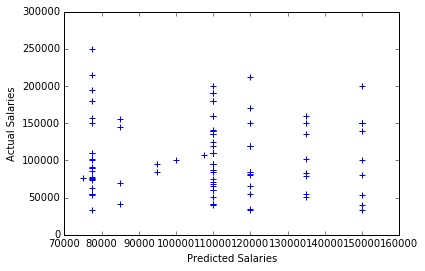

MSE: 2807127924.12


In [111]:
from sklearn.metrics import mean_squared_error
plt.scatter(ypredict, yknown, s=30, c='b', marker='+', zorder=10)
plt.xlabel("Predicted Salaries")
plt.ylabel("Actual Salaries")
plt.show()
print "MSE:", mean_squared_error(yknown, ypredict)